## Demo code for the bias-variance tradeoff

This notebook illustrates the bias-variance tradeoff when trying to fit a curve to data. (The statistical term for this is nonparametric regression.) 

We give simple, direct implementations of two algorithms. The first is called "kernel smoothing" and simply averages the $y$ values in the neighborhood of an $x$ value that we want to make a prediction for.  The second is very similar, but instead of just taking the average, we fit a line through those points.

As we average over smaller and smaller windows, the fitted function becomes more "wiggly." This corresponds to high variance, but low bias. Coversely, as we average over larger windows, the fitted function becomes smoother, but the squared bias increases. The "right" amount of smoothing will occur when the squared bias and the variance are roughly matched. 



In [1]:
import os, gzip
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
from time import sleep


In [2]:
def kernel_smooth(X, y, x, h):
    K = np.zeros(len(x)*len(X)).reshape(len(x), len(X))
    for j in np.arange(K.shape[1]):
        K[:,j] = (1/h)*np.exp(-(x-X[j])**2/(2*h**2))
        K[:,j] /= np.sum(K[:,j])
    fhat = np.dot(K, y) / np.sum(K, axis=1)
    return fhat

def local_linear_smooth(X, y, x, h):
    fhat = np.zeros(len(x))
    for i in np.arange(len(x)):
        W = np.diag((1/h)*np.exp(-(x[i]-X)**2/(2*h**2)))
        Xbar = np.append(X-x[i], np.ones(len(X))).reshape(2, len(X)).T
        beta = np.linalg.inv(Xbar.T @ W @ Xbar) @ Xbar.T @ W @ y
        fhat[i] = beta[1]
    return fhat

def plot_estimate(x, f, fhat, X, y, sigma, sleeptime=.2):
    clear_output(wait=True)
    plt.figure(figsize=(10,6))
    plt.plot(x, f, color='red', linewidth=2, label='true function')
    plt.plot(x, fhat, color='blue', linewidth=2, label='estimated function h=%.2f' % h)
    plt.scatter(X, y, color='black', alpha=.5, label='random sample')
    plt.ylim(np.min(f)-2*sigma, np.max(f)+2*sigma)
    plt.legend(loc='upper left')
    plt.show()
    sleep(sleeptime)
    
def true_fn(x):
    return 3*x**3
    # return 2*x*np.cos(1/x)

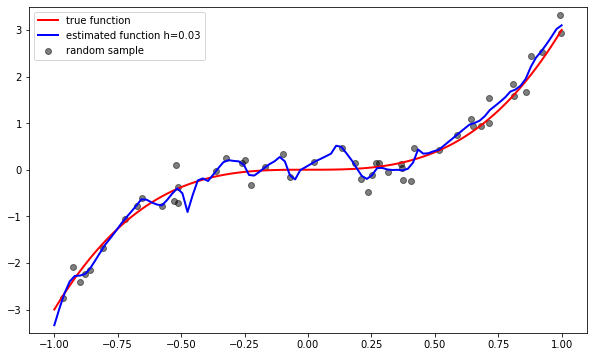

In [3]:
min_x, max_x = -1, 1

x = np.linspace(min_x, max_x, 100)
f = true_fn(x)
sigma = .25
estimates = []
bandwidths = [.6, .5, .4, .3, .2, .1, .075, .05, .025]
trials = 500

for h in bandwidths:
    estimates_h = []
    for i in np.arange(trials):
        X = np.sort(np.random.uniform(low=min_x, high=max_x, size=50))
        fX = true_fn(X)
        y = fX + sigma*np.random.normal(size=len(X))
        fhat = local_linear_smooth(X, y, x, h=h)
        if i < 10:
            plot_estimate(x, f, fhat, X, y, sigma, sleeptime=.1)
        estimates_h.append(fhat)
        
    estimates.append(estimates_h)

 

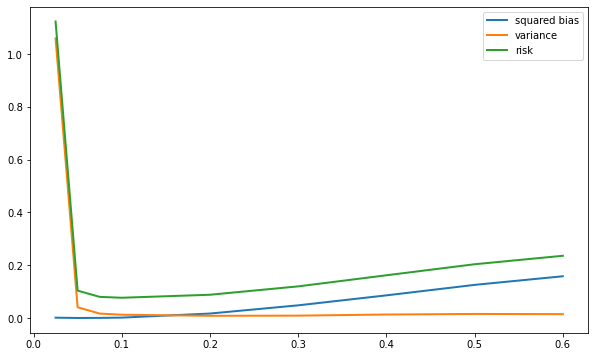

In [4]:
fhat = np.array(estimates)
sq_bias = np.zeros(len(bandwidths))
variance = np.zeros(len(bandwidths))

for i in np.arange(len(bandwidths)):
    sq_bias[i] = np.mean((np.mean(fhat[i], axis=0) - f)**2)
    variance[i] = np.mean(np.var(fhat[i], axis=0))
    
plt.figure(figsize=(10,6))
plt.plot(bandwidths, sq_bias, label='squared bias', linewidth=2)
plt.plot(bandwidths, variance, label='variance', linewidth=2)
plt.plot(bandwidths, sq_bias + variance + sigma**2, label='risk', linewidth=2)
plt.legend(loc='upper right')